In [8]:
import configargparse
import torch
import torch.optim as optim

from environments import CartPoleRegulatorEnv
from environments import CartEnv
from environments import AcrobotEnv
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

In [3]:
# Setup environment
bg_cart_mass = 1.0
fg_cart_mass = 1.0
init_experience = 400
force_left = 5
is_contrastive = False

train_env_bg = CartPoleRegulatorEnv(group=0, masscart=bg_cart_mass, mode="train", force_left=force_left, is_contrastive=is_contrastive)
train_env_fg = CartPoleRegulatorEnv(group=1, masscart=fg_cart_mass, mode="train", force_left=force_left, is_contrastive=is_contrastive)
eval_env_bg = CartPoleRegulatorEnv(group=0, masscart=bg_cart_mass, mode="eval", force_left=force_left, is_contrastive=is_contrastive)
eval_env_fg = CartPoleRegulatorEnv(group=1, masscart=fg_cart_mass, mode="eval", force_left=force_left, is_contrastive=is_contrastive)

# NFQ Main loop
bg_rollouts = []
fg_rollouts = []
total_cost = 0
if init_experience > 0:
    for _ in range(init_experience):
        rollout_bg, episode_cost = train_env_bg.generate_rollout(
            None, render=False, group=0
        )
        rollout_fg, episode_cost = train_env_fg.generate_rollout(
            None, render=False, group=1
        )
        bg_rollouts.extend(rollout_bg)
        fg_rollouts.extend(rollout_fg)
        total_cost += episode_cost

bg_rollouts.extend(fg_rollouts)
all_rollouts = bg_rollouts.copy()

bg_rollouts_test = []
fg_rollouts_test = []
if init_experience > 0:
    for _ in range(init_experience):
        rollout_bg, episode_cost = eval_env_bg.generate_rollout(
            None, render=False, group=0
        )
        rollout_fg, episode_cost = eval_env_fg.generate_rollout(
            None, render=False, group=1
        )
        bg_rollouts_test.extend(rollout_bg)
        fg_rollouts_test.extend(rollout_fg)
bg_rollouts_test.extend(fg_rollouts)
all_rollouts_test = bg_rollouts_test.copy()

/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
epoch = 3000
bg_success_queue = [0] * 3
fg_success_queue = [0] * 3
bg_converged = False

# Setup agent
nfq_net = ContrastiveNFQNetwork(state_dim=train_env_bg.state_dim, is_contrastive=is_contrastive)
optimizer = optim.Adam(nfq_net.parameters(), lr=1e-1)
nfq_agent = NFQAgent(nfq_net, optimizer)
for ep in range(epoch + 1):
    
    if bg_converged:
        state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(fg_rollouts)
    else:
        state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(bg_rollouts)
    
    loss = nfq_agent.train((state_action_b, target_q_values, groups))
    
    eval_episode_length_fg = 0
    eval_episode_length_bg = 0
    eval_success_fg = False
    eval_success_bg = False
    if bg_converged:
        eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg = nfq_agent.evaluate(
            eval_env_fg, render=False
        )
    else:
        eval_episode_length_bg, eval_success_bg, eval_episode_cost_bg = nfq_agent.evaluate(
        eval_env_bg, render=False
        )

    bg_success_queue = bg_success_queue[1:]
    bg_success_queue.append(1 if eval_success_bg else 0)

    fg_success_queue = fg_success_queue[1:]
    fg_success_queue.append(1 if eval_success_fg else 0)

    if sum(bg_success_queue) == 3:
        bg_converged = True

    if sum(fg_success_queue) == 3:
        print("FG Converged")
        break
    
    print("Epoch: " + str(ep) + " BG Converged: " + str(bg_converged) + " Eval BG: " + str(eval_episode_length_bg)
         + " Eval FG: " + str(eval_episode_length_fg))

Epoch: 0 BG Converged: False Eval BG: 20 Eval FG: 0
Epoch: 1 BG Converged: False Eval BG: 20 Eval FG: 0
Epoch: 2 BG Converged: False Eval BG: 31 Eval FG: 0
Epoch: 3 BG Converged: False Eval BG: 48 Eval FG: 0
Epoch: 4 BG Converged: False Eval BG: 68 Eval FG: 0
Epoch: 5 BG Converged: False Eval BG: 57 Eval FG: 0
Epoch: 6 BG Converged: False Eval BG: 33 Eval FG: 0
Epoch: 7 BG Converged: False Eval BG: 26 Eval FG: 0
Epoch: 8 BG Converged: False Eval BG: 25 Eval FG: 0
Epoch: 9 BG Converged: False Eval BG: 22 Eval FG: 0
Epoch: 10 BG Converged: False Eval BG: 22 Eval FG: 0
Epoch: 11 BG Converged: False Eval BG: 20 Eval FG: 0
Epoch: 12 BG Converged: False Eval BG: 29 Eval FG: 0
Epoch: 13 BG Converged: False Eval BG: 34 Eval FG: 0
Epoch: 14 BG Converged: False Eval BG: 86 Eval FG: 0
Epoch: 15 BG Converged: False Eval BG: 54 Eval FG: 0
Epoch: 16 BG Converged: False Eval BG: 60 Eval FG: 0
Epoch: 17 BG Converged: False Eval BG: 51 Eval FG: 0
Epoch: 18 BG Converged: False Eval BG: 50 Eval FG: 0
Epo

Epoch: 155 BG Converged: False Eval BG: 128 Eval FG: 0
Epoch: 156 BG Converged: False Eval BG: 85 Eval FG: 0
Epoch: 157 BG Converged: False Eval BG: 67 Eval FG: 0
Epoch: 158 BG Converged: False Eval BG: 135 Eval FG: 0
Epoch: 159 BG Converged: False Eval BG: 152 Eval FG: 0
Epoch: 160 BG Converged: False Eval BG: 77 Eval FG: 0
Epoch: 161 BG Converged: False Eval BG: 88 Eval FG: 0
Epoch: 162 BG Converged: False Eval BG: 105 Eval FG: 0
Epoch: 163 BG Converged: False Eval BG: 66 Eval FG: 0
Epoch: 164 BG Converged: False Eval BG: 602 Eval FG: 0
Epoch: 165 BG Converged: False Eval BG: 83 Eval FG: 0
Epoch: 166 BG Converged: False Eval BG: 136 Eval FG: 0
Epoch: 167 BG Converged: False Eval BG: 83 Eval FG: 0
Epoch: 168 BG Converged: False Eval BG: 115 Eval FG: 0
Epoch: 169 BG Converged: False Eval BG: 56 Eval FG: 0
Epoch: 170 BG Converged: False Eval BG: 122 Eval FG: 0
Epoch: 171 BG Converged: False Eval BG: 183 Eval FG: 0
Epoch: 172 BG Converged: False Eval BG: 131 Eval FG: 0
Epoch: 173 BG Conv

Epoch: 306 BG Converged: True Eval BG: 0 Eval FG: 124
Epoch: 307 BG Converged: True Eval BG: 0 Eval FG: 147
Epoch: 308 BG Converged: True Eval BG: 0 Eval FG: 130
Epoch: 309 BG Converged: True Eval BG: 0 Eval FG: 70
Epoch: 310 BG Converged: True Eval BG: 0 Eval FG: 124
Epoch: 311 BG Converged: True Eval BG: 0 Eval FG: 95
Epoch: 312 BG Converged: True Eval BG: 0 Eval FG: 60
Epoch: 313 BG Converged: True Eval BG: 0 Eval FG: 78
Epoch: 314 BG Converged: True Eval BG: 0 Eval FG: 76
Epoch: 315 BG Converged: True Eval BG: 0 Eval FG: 120
Epoch: 316 BG Converged: True Eval BG: 0 Eval FG: 58
Epoch: 317 BG Converged: True Eval BG: 0 Eval FG: 51
Epoch: 318 BG Converged: True Eval BG: 0 Eval FG: 116
Epoch: 319 BG Converged: True Eval BG: 0 Eval FG: 55
Epoch: 320 BG Converged: True Eval BG: 0 Eval FG: 63
Epoch: 321 BG Converged: True Eval BG: 0 Eval FG: 59
Epoch: 322 BG Converged: True Eval BG: 0 Eval FG: 73
Epoch: 323 BG Converged: True Eval BG: 0 Eval FG: 78
Epoch: 324 BG Converged: True Eval BG: 0

In [7]:
eval_env_bg.step_number = 0
eval_env_fg.step_number = 0

eval_env_bg.max_steps = 1000
eval_env_fg.max_steps = 1000

performance = []
evaluations = 10
total = 0
for it in range(evaluations):

    eval_episode_length_bg, eval_success_bg, eval_episode_cost_bg = nfq_agent.evaluate(eval_env_bg, True)
    performance.append(eval_episode_length_bg)
    train_env_bg.close()
    eval_env_bg.close()

    eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg = nfq_agent.evaluate(eval_env_fg, True)
    performance.append(eval_episode_length_fg)
    train_env_fg.close()
    eval_env_fg.close()

NameError: name 'sns' is not defined

/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

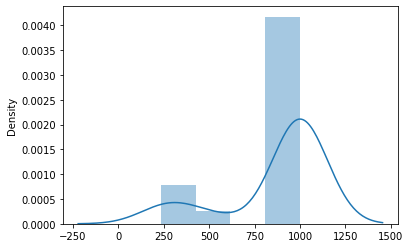

In [9]:
sns.distplot(performance)